In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import datetime
import json
from collections import Counter

import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO


# Newer clustering
### Aiding correlation algorithm
Since correlation alogrithm has high complexity, clustering can help us
 divide dataset in manner that groups most likely similar communications.
 The interest is that time correlation is paramount, therefore no other 
 features will be used other than those which would affect correlation.

So my idea is to cluster by start time and duration, the more similar the
 more likely is corelation. 
 
Now to make things faster, I will use preprocessed events in pandas.

First set will be filtered by range of times we are interested in... lets say
one hour

### Dataset
Data from .idea files are preprocessed into CSV for fast loading into pandas.
Pandas library is said to be excellent for data analysis. 

Here event tuples are aggregated by source IP and events for each are counted.
Before doing correlation with complexity n^2 one cas think about limits which
allow for two series to be correlated. This can be count of elements in ip-addresses
series of events. It is assumed that they are more likely to be correlated if 
counts are close. So dividing dataset into 'windows' can speed up process by not
trying to correlate only sets of ip which have +-some constant of events in series.
This can event regulate how much correlations algorithm finds. 

Following graphs demonstrate histogram of series lengths.

In [17]:
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)});

In [18]:
base="2019-08-01"
fname='../data/'+base+'_prep.json'

with open(fname,'r') as f:
    dfile = json.load(f)
    
A = pd.read_csv(StringIO(dfile['ips']))#([x.split(',') for x in dfile['ips'].split('\n')])
dfile['ips']=A

sf = datetime.datetime.fromisoformat(base+' 10:00:00').timestamp()
st = datetime.datetime.fromisoformat(base+' 11:00:00').timestamp()

B = A[A['time'] < st]
B = B[B['time'] >= sf]

print('There are {} in total and {} events after defined filtering time to 10:00-11:00 only'.format(A.shape,B.shape))

There are (1738335, 4) in total and (78217, 4) events after defined filtering time to 10:00-11:00 only


In [19]:
A.head()

,ip,origin,type,time
0,103.218.243.13,0,0,1564610356
1,148.72.210.28,0,0,1564610361
2,81.65.57.59,0,0,1564610356
3,194.156.126.76,0,0,1564610360
4,123.183.122.165,0,0,1564610395


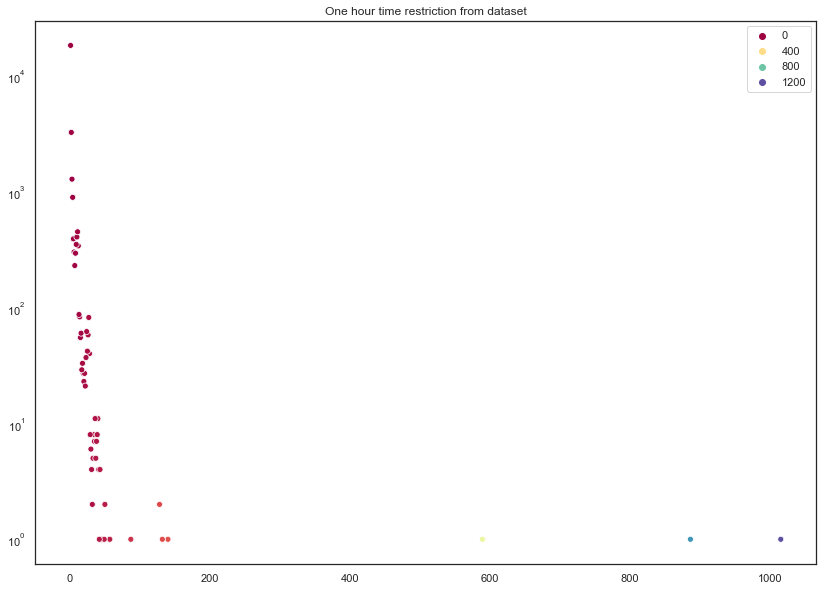

In [20]:
C=B.groupby('ip').count()['time']

c=Counter()
for idx, val in C.iteritems():
    c[val] += 1

grid=sns.scatterplot(palette='Spectral',x=list(c.keys()),y=list(c.values()),hue=list(c.keys()))
grid.set(yscale='log')
grid.set(title='One hour time restriction from dataset');


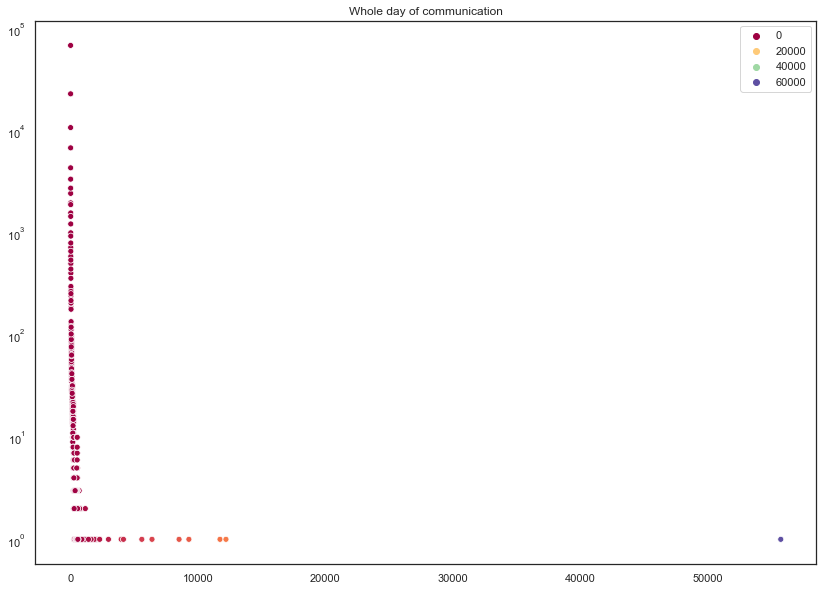

In [21]:
Aagg=A.groupby('ip').count()['time']

cnt=Counter()
for idx, val in Aagg.iteritems():
    cnt[val] += 1
    
grid=sns.scatterplot(palette='Spectral',x=list(cnt.keys()),y=list(cnt.values()),hue=list(cnt.keys()))
grid.set(yscale='log')
grid.set(title='Whole day of communication');

In [22]:

print('There are {} different series lengths.'.format(len(cnt)))


There are 610 different series lengths.


In [23]:
print('One hour set quantiles')
print(C.quantile([0.05,0.2,0.5,0.8,0.95]))
print('One day set quantiles')
print(Aagg.quantile([0.05,0.2,0.5,0.8,0.95]))


One hour set quantiles
0.05     1.0
0.20     1.0
0.50     1.0
0.80     3.0
0.95    11.0
Name: time, dtype: float64
One day set quantiles
0.05     1.0
0.20     1.0
0.50     2.0
0.80     7.0
0.95    40.0
Name: time, dtype: float64


# Clustering and features to use
### Features
Given no literature reading, I need to know what is purpose of time correlation, what
type of correlations are we interested in to pick proper features for clustering. 
If we are looking to time correlate across groups, which can decrease complexity
we can cluster similar types of communications by looking at either counts or bit 
bitfields of types of events for each IP. Then the more correlations from group X to Y
the more likely that this two types of communications succeed each other.

It is already known that after scanning there are login attempts following so I can
propose how to make algorithm which will reveal such phenomena

Divide events (data) into groups by types of events. Do time correlation across groups
and in counters for all combinations calculate probability like this eg.:
 actual correlation/total possible where unit can be event vs series of events.
 
There is information available about where the events come from, what are the types of events
possibly more. Now one can generate features by unpacking this into true/false in separate
dimensions and select most significant for clustering.

Remember SVD, PCA, LDA and more


### Experiment
For sake of experiment let me do one arbitrarily chosen clustering scenario.
Lets cluster the hour restricted set and use bit fields of types of events along
with duration and count.

### Graphing
There are three graphs for each analysis:
    * First is coloured by duration
    * Second marks where count is higher than x
    * Third uses dominant event type from the series

### Clusetering scenario
Features describing time-series of ips are

| name | descr |
| --- | --- |
| duration | last - first observed |
| count | count of events |
| itarmed | median of inter arrival time list |
| itarmean | mean time between arrivals |
| itardev | standard deviation of times between arrivals |

Other than that bit-vector for event types is also used during clustering


In [24]:
#A = pd.read_csv('../data/2019-03-11_prep.csv',header=0)
#with open('../data/2019-03-11_prep.json','r') as f:
#    Aj = json.load(f)

sf = datetime.datetime.fromisoformat(base+' 10:00:00').timestamp()
st = datetime.datetime.fromisoformat(base+' 11:00:00').timestamp()

B = A[A['time']<st]
B = B[B['time']>=sf]
#B = B[B['type']!= dfile['type']['1']]

In [25]:
feat = pd.DataFrame(columns=(tuple(['ip']+list(dfile['types'].values())+['count']+['duration'])))

feat.ip = B.ip
feat.fillna(0, inplace=True)

for key, val in dfile['types'].items():
    feat[val] = B['type'] == int(key)
    #Bfeat = B.groupby('ip')


             Attempt.Login  Recon.Scanning  Malware.Ransomware  Malware  \
ip                                                                        
1.0.134.78           False            True               False    False   
1.0.196.221          False            True               False    False   
1.0.206.49           False            True               False    False   
1.0.247.1            False            True               False    False   
1.0.253.198          False            True               False    False   

             Fraud.Phishing  Availability.DoS  Other  Abusive.Spam  \
ip                                                                   
1.0.134.78            False             False  False         False   
1.0.196.221           False             False  False         False   
1.0.206.49            False             False  False         False   
1.0.247.1             False             False  False         False   
1.0.253.198           False             False  False  

,count,duration,itarmed,itarmean,itardev
count,27295.000000,27295.000000,27295.000000,27295.000000,27295.000000
mean,2.865616,732.856127,179.571112,173.246486,144.574563
std,10.059873,1187.835694,327.421261,308.676473,288.632736
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000
75%,2.000000,1358.000000,301.000000,282.219697,132.720077
max,1015.000000,3594.000000,1774.000000,1774.000000,1774.000000


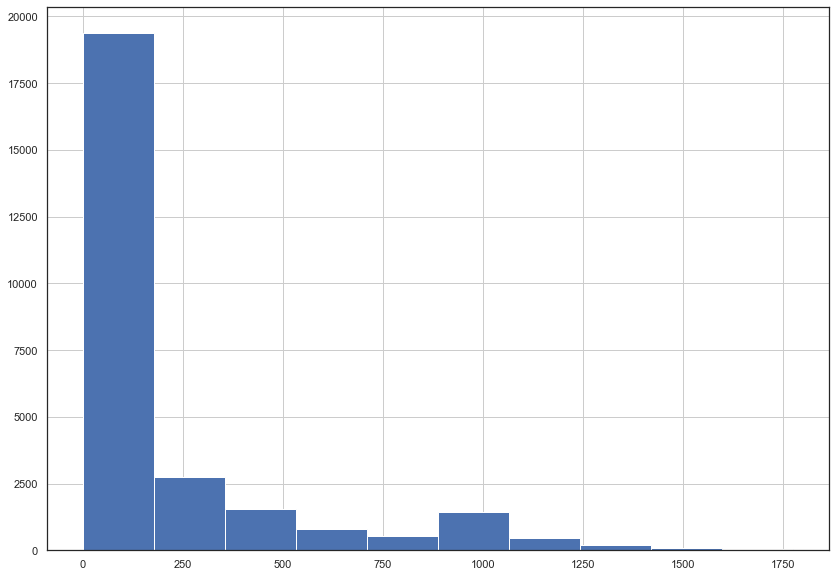

In [26]:

aggregation = {
    #'time': [lambda x: np.log(max(x)-min(x)+1), "count"]
    'time': [('duration', lambda x: (max(x)-min(x)+1)),
             ('count', "count"), 
             ('itarmed', lambda y: np.quantile((np.array(sorted(list(y))+[max(y)])-np.array([min(y)]+sorted(list(y))))[1:], 0.5)),
             ('itarmean', lambda y: np.mean((np.array(sorted(list(y))+[max(y)])-np.array([min(y)]+sorted(list(y))))[1:])),
             ('itardev', lambda y: np.std((np.array(sorted(list(y))+[max(y)])-np.array([min(y)]+sorted(list(y))))[1:])),
             
             #('list', lambda y: (np.array(sorted(list(y))+[max(y)])-np.array([min(y)]+sorted(list(y))))[1:]),
             #('itar25', lambda y: np.quantile(np.array(sorted(list(y))+[0])-np.array([0]+sorted(list(y))), 0.25)),
             #('itar75', lambda y: np.quantile(np.array(sorted(list(y))+[0])-np.array([0]+sorted(list(y))), 0.75))
             ]
}

labeling = {
    'type': [lambda x: dfile['types'][str(Counter(list(x)).most_common(1)[0][0])]]
}

series = {
    #'time': [lambda x: np.log(max(x)-min(x)+1), "count"]
    'time': [('list', lambda y: (np.array(sorted(y)+[max(y)])-np.array([min(y)]+sorted(y)))),
            ]
}


featag = feat.groupby('ip').max()
#featag[['duration', 'count', 'itarmed','itar25','itar75']]=B.groupby('ip').agg(aggregation)
featag[['duration', 'count', 'itarmed', 'itarmean', 'itardev']]=B.groupby('ip').agg(aggregation)

featag['label']=B.groupby('ip').agg(labeling)

featag.itarmed.hist()
print(featag.head())
##%%
#featag.itarmed.hist()
#featag.itar25.hist()
#featag.itar75.hist()
##%%
#print(featag.iloc[:,:-2].columns)
featag.describe()

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not

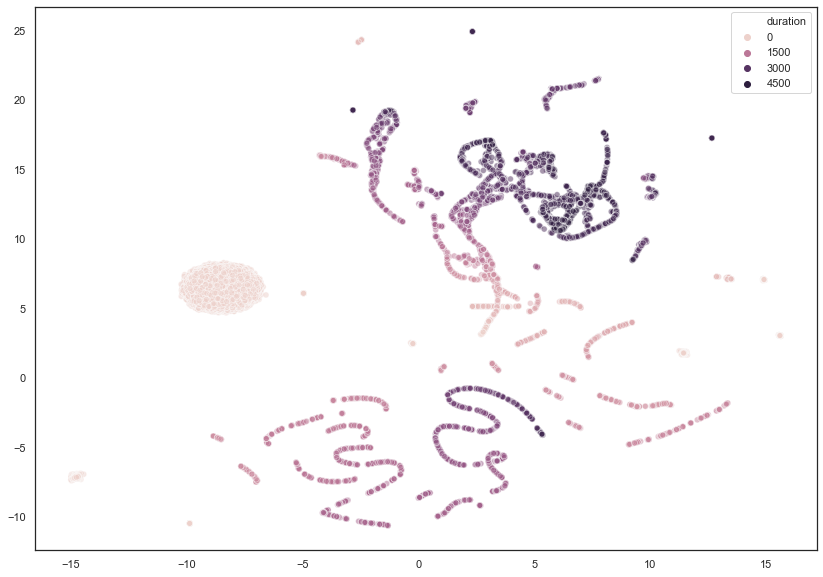

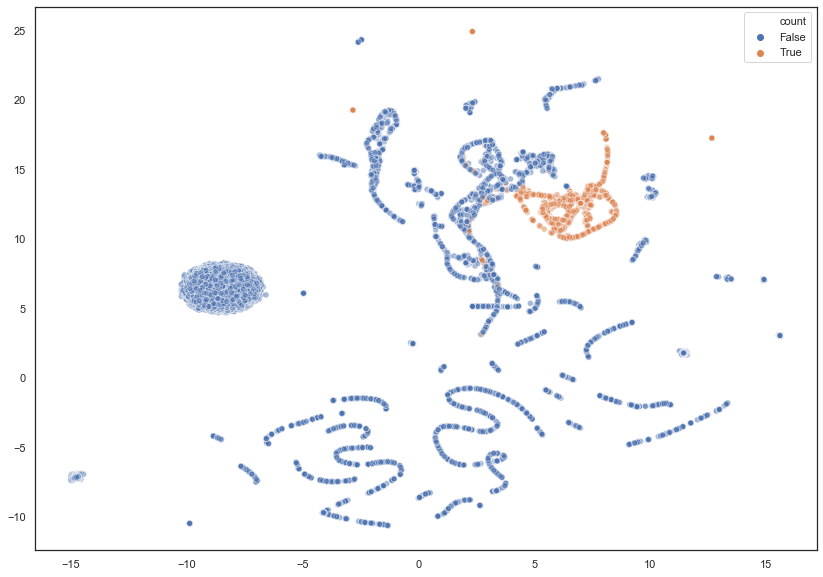

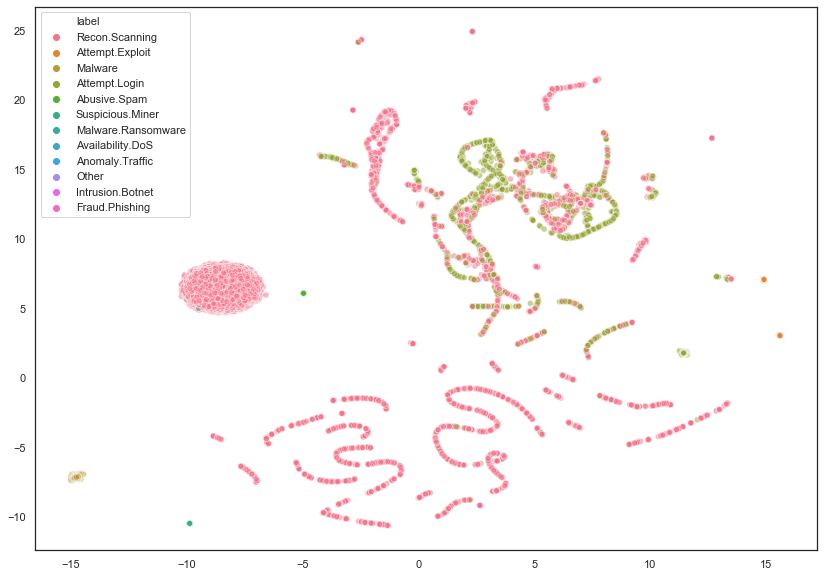

In [27]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(featag.iloc[:,:-1])
embedding.shape

plt.figure()
p1=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag['duration'], alpha=0.5)
plt.figure()
p2=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag['count']>10, alpha=0.5)
plt.figure()
p3=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag['label'], alpha=0.5)


### Clustering scenario
Here it is same as above, only bit-vector is changed to counts.
 

In [28]:
featcnt = feat.groupby('ip').count()
#featag[['duration', 'count', 'itarmed','itar25','itar75']]=B.groupby('ip').agg(aggregation)
featcnt[['duration', 'count', 'itarmed', 'itarmean', 'itardev']]=B.groupby('ip').agg(aggregation)

featcnt['label']=B.groupby('ip').agg(labeling)

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 14 separate connected components using meta-embedding (experimental)
  n_components
C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is no

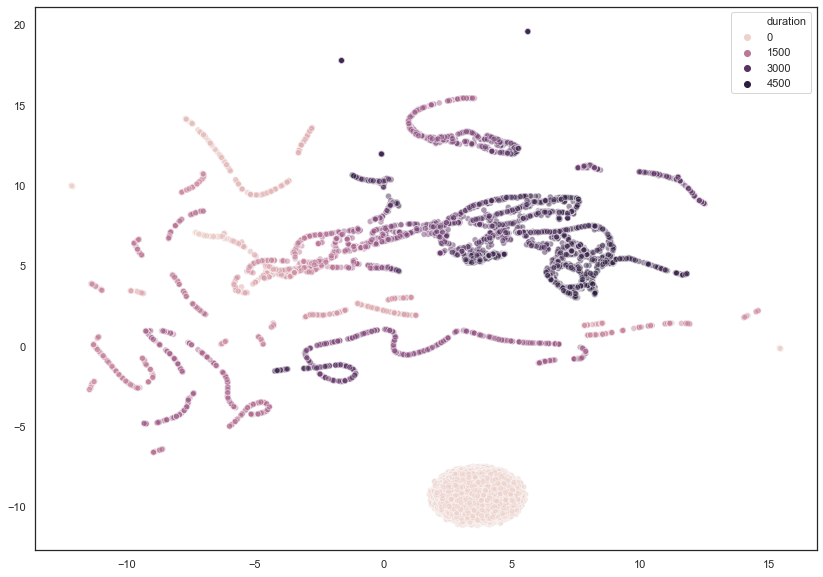

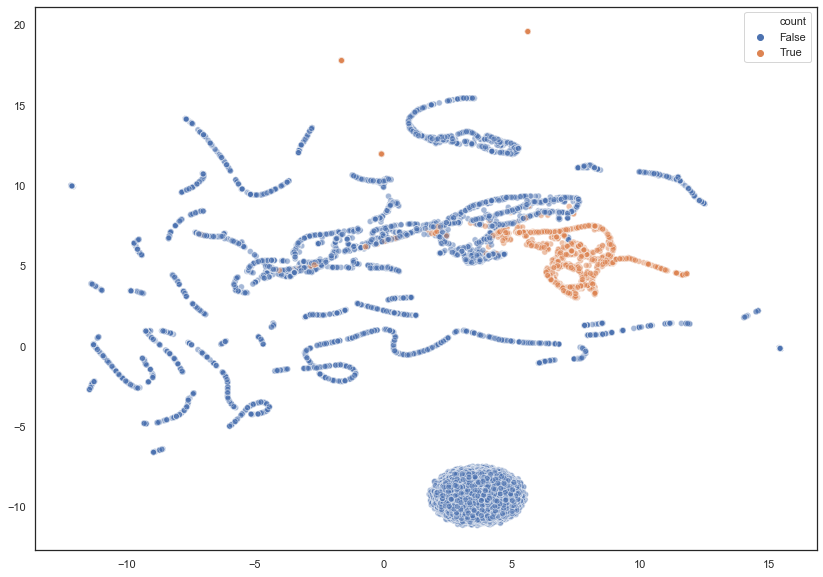

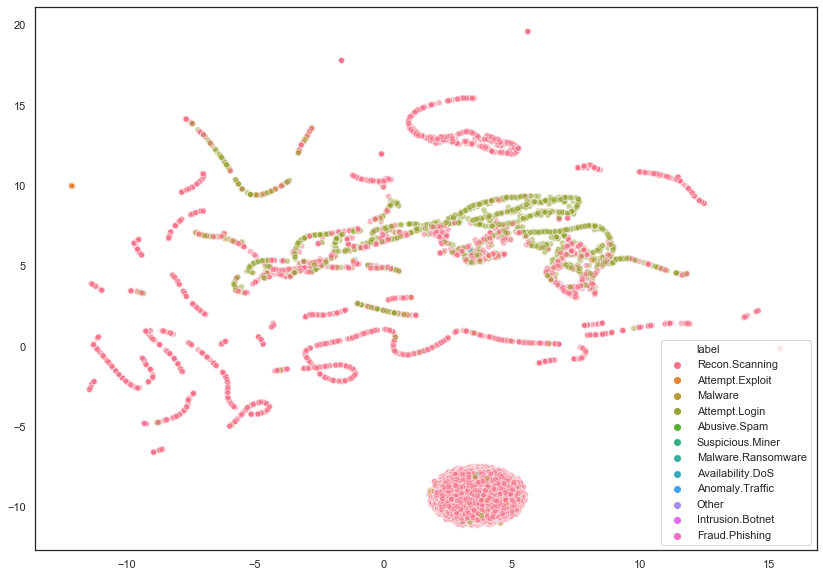

In [29]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(featcnt.iloc[:,:-1])#((featag-featag.mean())/featag.std()))
embedding.shape

p1=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featcnt['duration'], alpha=0.5)
plt.figure()
p2=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featcnt['count']>10, alpha=0.5)
plt.figure()
p3=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featcnt['label'], alpha=0.5)


### Dataset insights
Insight into some values in dataset


In [40]:
series = {
    #'time': [lambda x: np.log(max(x)-min(x)+1), "count"]
    'time': [('list', lambda y: (np.array(sorted(y)+[max(y)])-np.array([min(y)]+sorted(y)))),
            ]
}

featag[['duration', 'count', 'itarmed', 'itarmean', 'itardev']]=B.groupby('ip').agg(aggregation)
#tseries = B.groupby('ip').agg(series)
print(featag.loc[featag['count']>10,['duration','count','itarmed','itarmean','itardev']])
print(tseries[featag['count']>10])


                 duration  count  itarmed    itarmean     itardev
ip                                                               
1.165.9.133          3300     12    299.5  274.916667   83.080742
1.32.52.118          3300     14    296.5  235.642857  101.460483
1.54.5.189           3320     12    301.0  276.583333   83.413087
10.130.25.1          3533    140     17.0   25.228571   26.034412
10.81.52.183         3300     12    299.5  274.916667   83.080742
101.187.39.74        3469     12    315.0  289.000000   87.319337
101.81.125.26        3351     11    319.0  304.545455   99.627820
102.165.35.91        3300     15    289.0  219.933333  107.956452
102.165.38.242       3466     12    313.0  288.750000   87.401492
102.165.52.215       3139     18    178.0  174.333333  125.494134
103.1.210.105        3390     34     69.0   99.676471   92.213219
103.100.208.221      3303     15    304.0  220.133333  122.105346
103.101.205.68       3378     26     63.0  129.884615   99.504668
103.121.24

For comparision what happens if for clustering we omit ip with low quantity of events in series
let's say only 10 and more?


(1662, 2)


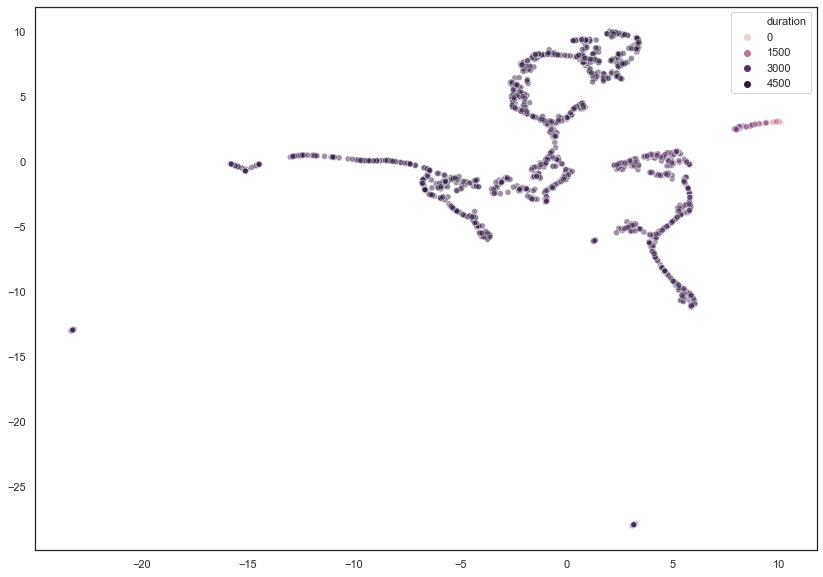

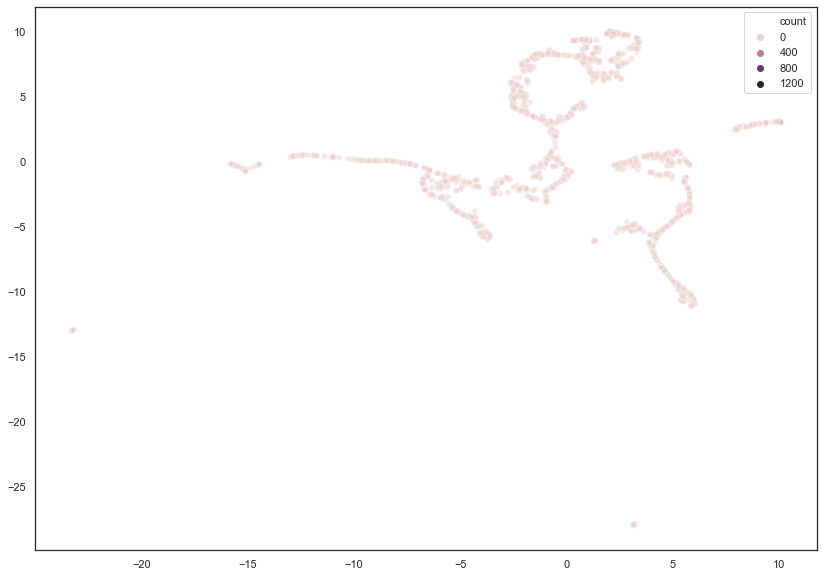

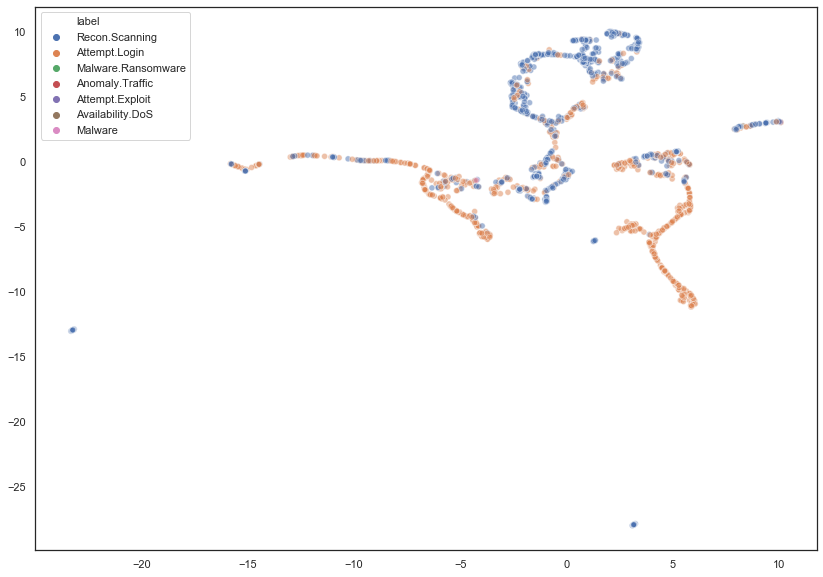

In [41]:
reducer = umap.UMAP()
featag_short = featag[featag['count']>10]

embedding = reducer.fit_transform(featag_short.iloc[:,:-1])
print(embedding.shape)

plt.figure()
p1=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag_short['duration'], alpha=0.5)
plt.figure()
p2=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag_short['count'], alpha=0.5)
plt.figure()
p3=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag_short['label'], alpha=0.5)

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


(13235, 2)


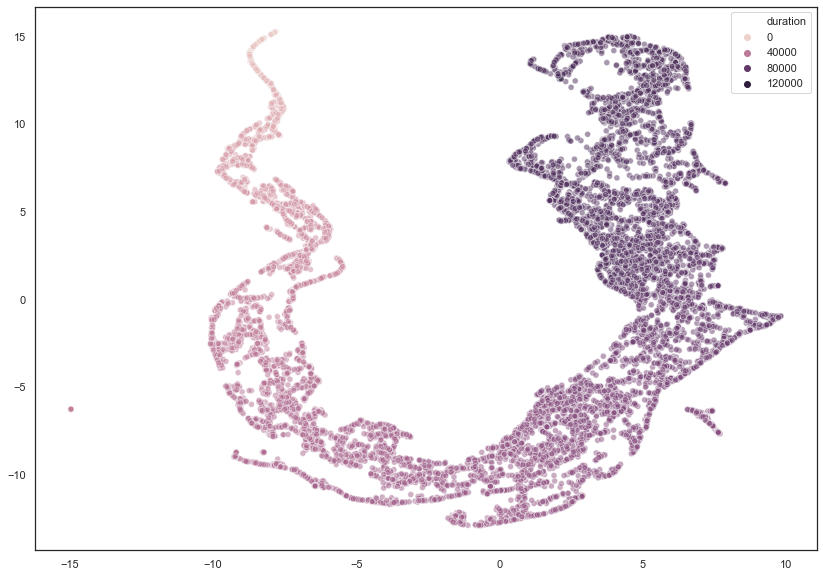

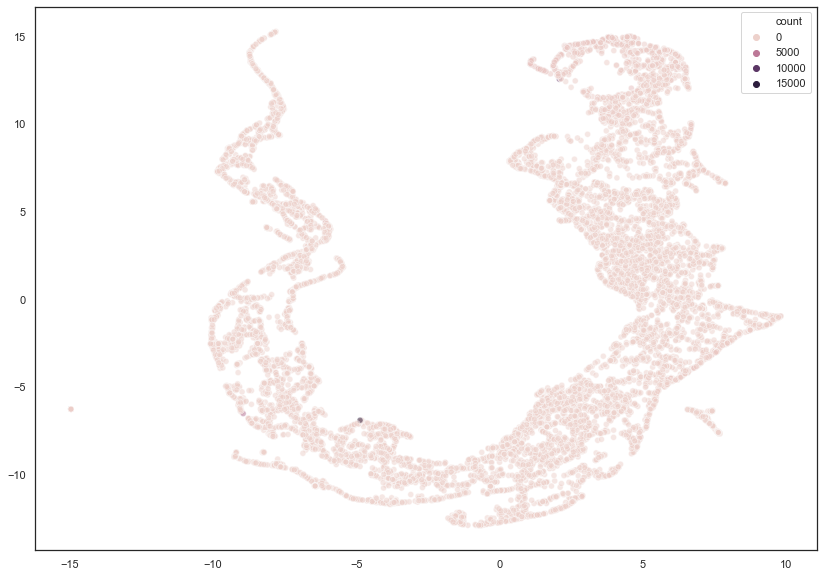

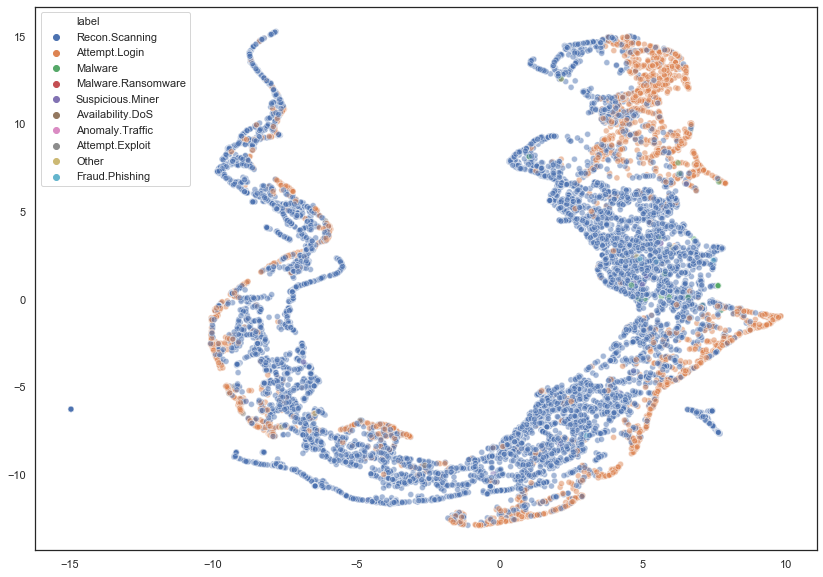

In [42]:
feat2 = pd.DataFrame(columns=(tuple(['ip']+list(dfile['types'].values())+['count']+['duration'])))

feat2.ip = A.ip
feat2.fillna(0, inplace=True)

for key, val in dfile['types'].items():
    feat2[val] = A['type'] == int(key)
featag2 = feat.groupby('ip').max()

#featag[['duration', 'count', 'itarmed','itar25','itar75']]=B.groupby('ip').agg(aggregation)
featag2[['duration', 'count', 'itarmed', 'itarmean', 'itardev']]=A.groupby('ip').agg(aggregation)

featag2['label']=A.groupby('ip').agg(labeling)

reducer = umap.UMAP()
featag2_short = featag2[featag2['count']>10]

embedding = reducer.fit_transform(featag2_short.iloc[:,:-1])
print(embedding.shape)

plt.figure()
p1=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag2_short['duration'], alpha=0.5)
plt.figure()
p2=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag2_short['count'], alpha=0.5)
plt.figure()
p3=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag2_short['label'], alpha=0.5)

In [43]:
embedding = reducer.fit_transform(featag2_short.loc[:,['count', 'itarmed', 'itarmean', 'itardev']])
print(embedding.shape)

C:\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\numba\compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\ProgramData\Anaconda3\envs\temporal_event_corr\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


(13235, 2)


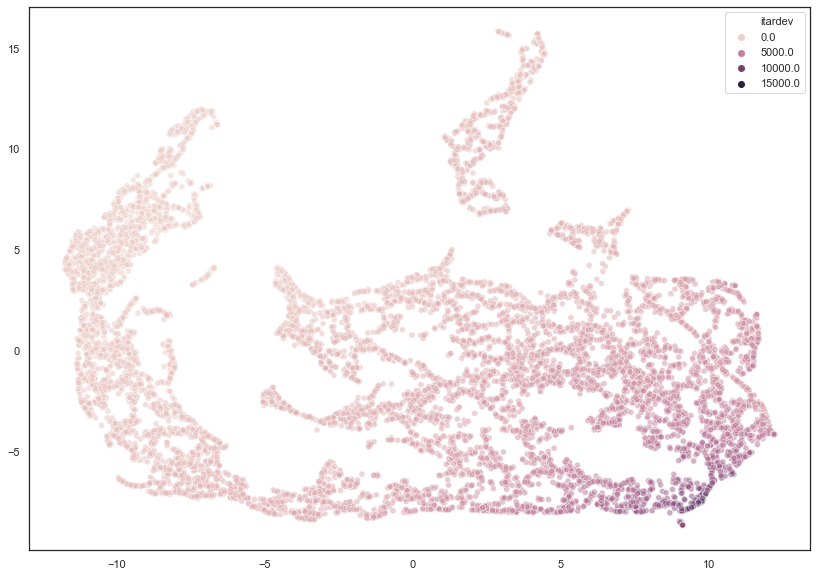

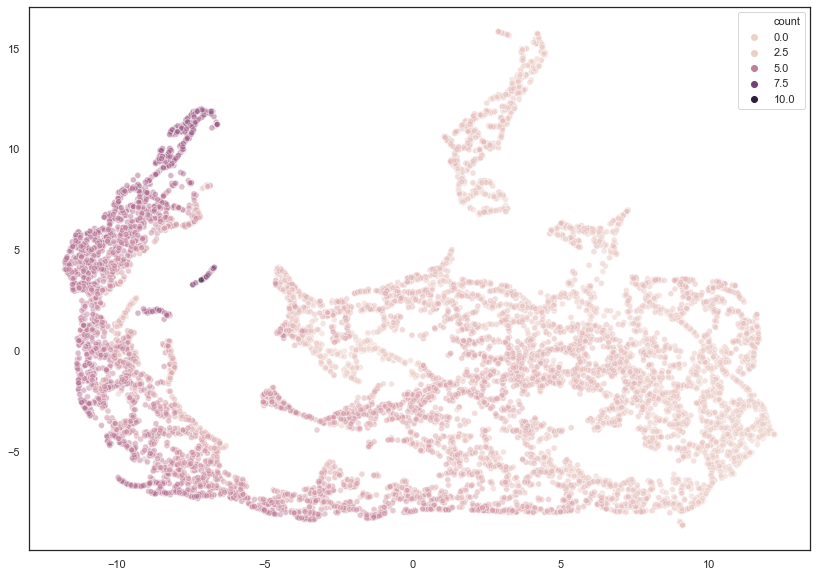

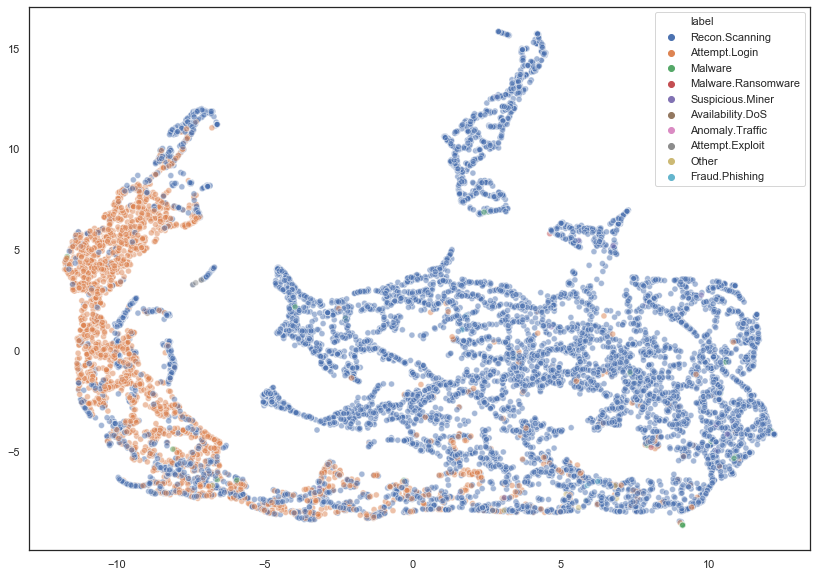

In [44]:
plt.figure()
p1=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag2_short['itardev'], alpha=0.5)
plt.figure()
p2=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=np.log(featag2_short['count']), alpha=0.5)
plt.figure()
p3=sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=featag2_short['label'], alpha=0.5)

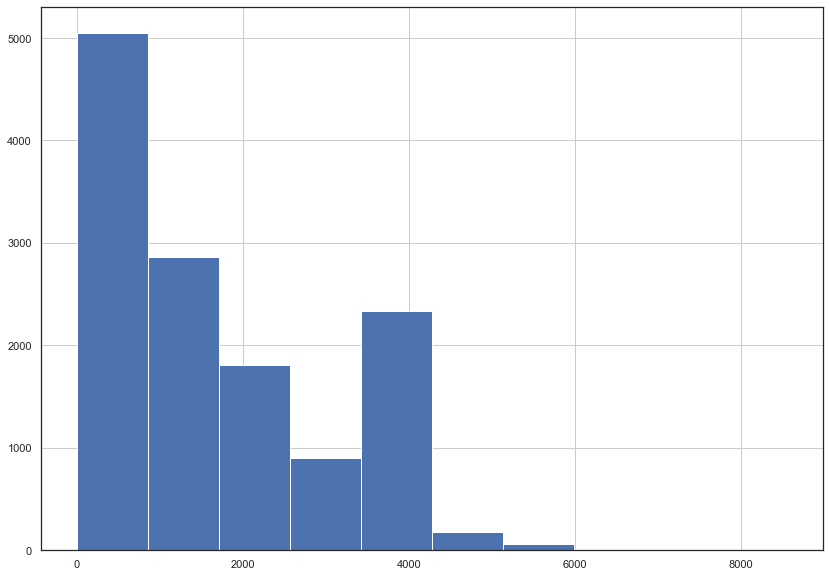

In [45]:
featag2_short.itarmed.hist()

In [3]:
sns.scatterplot(data=featag2_short, x='itarmed', y='itarmean', hue='count', alpha=0.5)
plt.figure()
sns.scatterplot(data=featag2_short, x='itarmed', y='itarmean', hue=np.log(featag2_short['count']), alpha=0.5)

NameError: name 'featag2_short' is not defined

In [47]:
#print(tseries[tseries['ip']=='185.200.118.46' or tseries['ip']=='185.200.118.46',:])

In [ ]:
#make graphs with dependencies of axes at each other colour by dominant type

